#### CSCE 670 :: Information Storage and Retrieval :: Texas A&M University :: Spring 2017


# Project: Different Faces of a City


Team members: ...

Project description here...

## Introduction

This project ...

The paper we are referring to...
* http://courses.cse.tamu.edu/caverlee/csce670_2013/livehoods-paper.pdf

We implemented **our algorithm** from scratch.

You can see the code below...



In [1]:
# Data Structure

import string
import glob, os
import re
import math

# Input: Filename of checkin data
# Return: {venueid : [{userid : time}, {userid : time}, ...], ... }

def get_venue_checkin(filename):
    ret = {}
    
    fp = open(filename, 'r')
    lines = fp.readlines()
    
    for line in lines:
        checkin_time = {}
        arr = re.split("\t", line)
        
        userid = arr[0]
        venueid = arr[1]
        time = re.split(' ', arr[2])
        hour = time[3][0:2]
        
        checkin_time[userid] = hour

        if not ret.has_key(venueid):
            ret[venueid]=[checkin_time]
        else:
            ret[venueid].append(checkin_time)
            
    return ret

#austin_venue_checkin = get_venue_checkin("austin_checkin.txt")
houston_venue_checkin = get_venue_checkin("houston_checkin.txt")

In [2]:
# Input: Filename of checkin data
# Return: {venueid : {"latitiude" : latitude, "longitude" : longitude, "type" : type}, ...}

def get_venue_info(filename):
    ret = {}
    
    fp = open(filename, 'r')
    lines = fp.readlines()

    for line in lines:
        arr = re.split("\t", line)
        
        venue_info = {}
        
        venueid = arr[0]
        venue_info["latitude"] = arr[1]
        venue_info["longitude"] = arr[2]
        venue_info["type"] = arr[3]
        
        ret[venueid] = venue_info

    return ret

#austin_venue = get_venue_info("austin_venue.txt")
houston_venue = get_venue_info("houston_venue.txt")

In [3]:
# Create hour histogram
# Input: Filename of checkin data, period in hours
# Return: [freq@0-period, freq@1-2*period, ...]

def create_histogram(filename, period):
    ret = {}
    
    fp = open(filename, 'r')
    lines = fp.readlines()

    for line in lines:
        arr = re.split('\t', line)
        
        time = re.split(' ', arr[2])
        hour = int(int(time[3][0:2])/period)
        
        if not ret.has_key(hour):
            ret[hour] = 1
        else:
            ret[hour] += 1
            
    sorted_keys = sorted(ret)
    
    ret_list = []
    
    for k in sorted_keys:
        ret_list.append((k, ret[k]))
            
    return ret_list

#austin_histogram = create_histogram("austin_checkin.txt", 1)
houston_histogram = create_histogram("houston_checkin.txt", 1)

In [4]:
from collections import defaultdict

# Input: Filename of checkin data, period in hours
# Return: {hour : {venueid : {userid : checkin_freq, ...}, ...}, ...}

def get_checkin_freq_by_hour(filename):
    ret = defaultdict(lambda : defaultdict(dict))
    
    fp = open(filename, 'r')
    lines = fp.readlines()

    for line in lines:
        arr = re.split('\t', line)
        
        userid = arr[0]
        venueid = arr[1]
        time = re.split(' ', arr[2])
        hour = int(time[3][0:2])
        if not ret.has_key(hour):
            ret[hour][venueid][userid] = 1
        else:
            if not ret[hour].has_key(venueid):
                ret[hour][venueid][userid] = 1
            else:
                if not ret[hour][venueid].has_key(userid):
                    ret[hour][venueid][userid] = 1
                else:
                    ret[hour][venueid][userid] += 1
                    
    return ret
    
#austin_checkin_freq = get_checkin_freq_by_hour("austin_checkin.txt")
houston_checkin_freq = get_checkin_freq_by_hour("houston_checkin.txt")

In [5]:
# Input: {hour : {venueid : {userid : checkin_freq, ...}, ...}, ...}, 
#        {venueid : {"latitiude" : latitude, "longitude" : longitude, "type" : type}, ...},
#        period in hours
# Return {hour : {venue_type : freq, ...}, ...}

def create_pie_chart(freq, info):
    ret = {}
    
    for hour, venues in freq.iteritems():
        for venueid, users in venues.iteritems():
            venue_type = info[venueid]["type"]
            
            checkin_total = 0
            for userid, checkin_count in users.iteritems():
                checkin_total += checkin_count
                
            if not ret.has_key(hour):
                ret[hour] = {}
                ret[hour][venue_type] = checkin_total
                
            else:
                if not ret[hour].has_key(venue_type):
                    ret[hour][venue_type] = checkin_total
                else:
                    ret[hour][venue_type] += checkin_total
                    
    return ret

#austin_pie_chart = create_pie_chart(austin_checkin_freq, austin_venue, 1)
houston_pie_chart = create_pie_chart(houston_checkin_freq, houston_venue)

In [6]:
# Input: {userid : freq, ...}
# Return: {userid : normalized_freq, ...}

def normalized(vect):
    ret = {}
    
    total = 0
    
    for userid, freq in vect.iteritems():
        total += freq**2
    
    normalizer = math.sqrt(total)
    
    for userid, freq in vect.iteritems():
        ret[userid] = float(float(freq)/float(normalizer))
        
    return ret

In [7]:
from math import radians, cos, sin, asin, sqrt

# Taken from Micheal Dunn from post http://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points

def distance(v1, v2):
    lon1 = float(v1["longitude"])
    lat1 = float(v1["latitude"])
    lon2 = float(v2["longitude"])
    lat2 = float(v2["latitude"])

    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [39]:
# Input: filename, number of nearest venues
# Return: {venueid : [venueid, ...], ...}

def get_nearest_venues(filename, n):
    ret = {}

    fp = open(filename, 'r')
    lines = fp.readlines()

    for line in lines:
        arr = re.split(':', line)
        
        venueid = arr[0]
        nearest_list = re.split(',', arr[1])
        
        ret[venueid] = nearest_list[0:n]
             
    return ret

#austin_nearest = get_nearest_venues("nearest_neighbors_austin.txt", 10)
houston_nearest = get_nearest_venues("nearest_neighbors_houston.txt", 30)

In [9]:
# Compute 1000 nearest neigbors for later computation
# Input: filaname, {venueid : {"latitiude" : latitude, "longitude" : longitude, "type" : type}, ...}
# Return: None
# Output: To file: venueid:1st_nearest_venueid,2nd_nearest_venueid,...

def preprocess_nearest_venues(filename, info):
    fp = open(filename, 'a')
    l = len(info)
    c = 0
    n = 1000
    for v1 in info.keys():
        if c % (l/100) == 0:
            print str(c*100.0/float(l))+"%"
        c += 1
        
        dist = []
        for v2 in info.keys():
            if v1 == v2:
                continue
                
            d = distance(info[v1], info[v2])
            dist.append((v2, d))
        dist.sort(key = lambda elem: elem[1])
        s = ""
        
        i = 0
        for e in dist:
            if i >= 1000:
                break
            s += e[0]+","
            i += 1
            
        fp.write(v1+":"+s[:-1]+"\n")
        
#preprocess_nearest_venues("nearest_neighbors_austin_1000.txt", austin_venue)
#preprocess_nearest_venues("nearest_neighbors_houston_1000.txt", houston_venue)

In [10]:
# Input: {userid : freq, ...}, {userid : freq, ...}
# Return: similarity score

def cosine_sim(vec1, vec2):
    ret = 0
    
    v1 = normalized(vec1)
    v2 = normalized(vec2)
    
    common_keys = list(set(v1.keys()) & set(v2.keys()))
    
    for k in common_keys:
        ret += v1[k]*v2[k]
    
    return ret

In [41]:
# Input: {venueid : {userid : checkin_freq, ...}, ...},
#        {venueid : [venueid, ...], ...}
# Return: Nv x Nv Affinity Matrix; Nv = # venues
#         {venueid : {venueid : score, ...}, ...}

def create_affinity_matrix(venues, nearest):
    alpha = 0.1
    
    ret = {}
    
    l = len(venues)
    c = 0
    
    for v1 in venues.keys():
        ret[v1] = {}
        
        if c % (l/100) == 0:
            print str(c*100.0/float(l))+"%"
        c += 1

        for v2 in venues.keys():
            if v2 in nearest[v1] or v1 in nearest[v2]:
                ret[v1][v2] = cosine_sim(venues[v1], venues[v2]) + alpha
            else:
                ret[v1][v2] = 0
        
#         for v2 in nearest[v1]:
#             ret[v1][v2] = cosine_sim(venues[v1], venues[v2]) + alpha

    return ret

#austin_affinity = create_affinity_matrix(austin_checkin_freq[0], austin_nearest)
houston_affinity = create_affinity_matrix(houston_checkin_freq[0], houston_nearest)

0.0%
0.974025974026%
1.94805194805%
2.92207792208%
3.8961038961%
4.87012987013%
5.84415584416%
6.81818181818%
7.79220779221%
8.76623376623%
9.74025974026%
10.7142857143%
11.6883116883%
12.6623376623%
13.6363636364%
14.6103896104%
15.5844155844%
16.5584415584%
17.5324675325%
18.5064935065%
19.4805194805%
20.4545454545%
21.4285714286%
22.4025974026%
23.3766233766%
24.3506493506%
25.3246753247%
26.2987012987%
27.2727272727%
28.2467532468%
29.2207792208%
30.1948051948%
31.1688311688%
32.1428571429%
33.1168831169%
34.0909090909%
35.0649350649%
36.038961039%
37.012987013%
37.987012987%
38.961038961%
39.9350649351%
40.9090909091%
41.8831168831%
42.8571428571%
43.8311688312%
44.8051948052%
45.7792207792%
46.7532467532%
47.7272727273%
48.7012987013%
49.6753246753%
50.6493506494%
51.6233766234%
52.5974025974%
53.5714285714%
54.5454545455%
55.5194805195%
56.4935064935%
57.4675324675%
58.4415584416%
59.4155844156%
60.3896103896%
61.3636363636%
62.3376623377%
63.3116883117%
64.2857142857%
65.259740

In [22]:
# c = 0
# for k, v in austin_affinity.iteritems():
#    for kk, vv in v.iteritems():
#        if vv != 0.01:
#            c += 1
#            print vv
# print c
# print len(austin_affinity)*10
# print austin_affinity

# def get_nearest_venues_tmp(filename, n):
#    reader = open(filename+"_1000.txt", 'r')
#    writer = open(filename+".txt", 'w')
   
#    lines = reader.readlines()

#    for line in lines:
#        arr = re.split(':', line)
       
#        venueid = arr[0]
#        nearest_list = re.split(',', arr[1])
       
#        s = str(venueid) + ":"
       
#        for e in nearest_list[0:n]:
#            s += str(e) + ","
           
#        writer.write(s[:-1])

# get_nearest_venues_tmp("nearest_neighbors_austin", 100)
# get_nearest_venues_tmp("nearest_neighbors_houston", 100)

Here is a general version of Spectral clustering algorithm


Noise cluster:  2
Cluster size:  1602


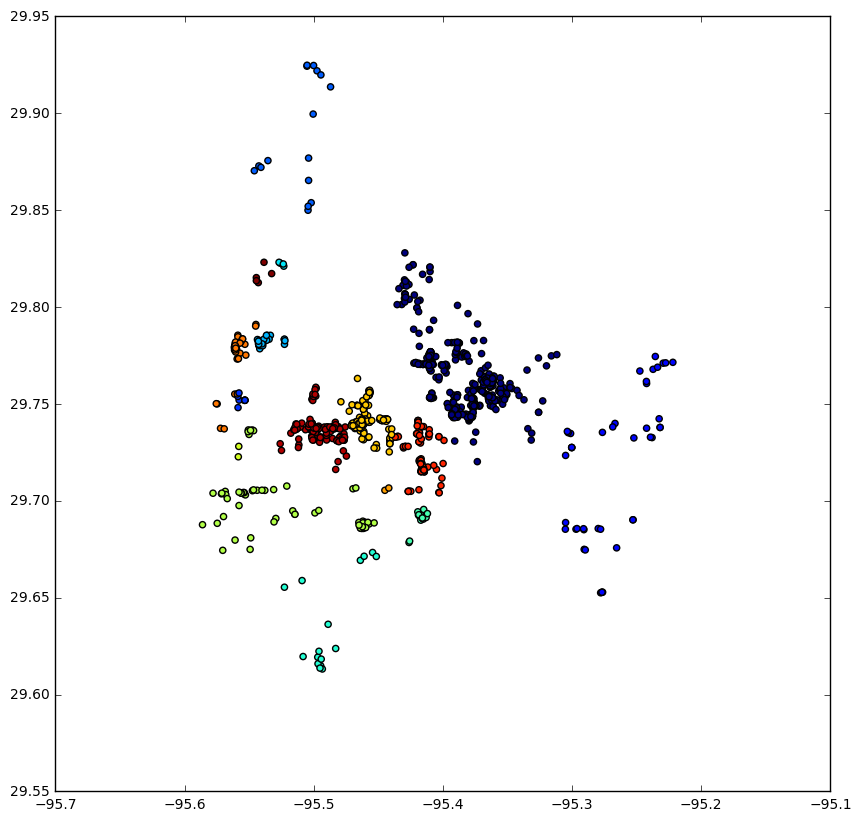

Clustering completed


In [82]:
# General version of Spectral clustering algorithm

import operator
import json
# import numpy as np
# import matplotlib.pyplot as plt

# from sklearn.feature_extraction import image
# from sklearn.cluster import SpectralClustering

# affinity_matrix = []

# l = len(houston_affinity)
# c = 0

# for k in houston_affinity:
    
#     if c % (l/100) == 0:
#         print str(c*100.0/float(l))+"%"
#     c += 1
    
#     temp_matrix = []
#     for k2 in houston_affinity[k]:
#         temp_matrix.append(houston_affinity[k][k2])
#     affinity_matrix.append(np.array(temp_matrix))

# affinity_matrix = np.array(affinity_matrix)
    
# print affinity_matrix.shape

# #labels = spectral_clustering(graph, n_clusters = 4, eigen_solver = 'arpack')
# sc = SpectralClustering(n_clusters = 25, n_jobs = -1, affinity = 'precomputed')
# sc.fit(affinity_matrix)

# labels = sc.labels_

cluster = {}
c = 0

for v in houston_affinity:
    cluster[v] = labels[c]
    c += 1

cluster_count = {}

for v in houston_venue:
    if v in houston_affinity:
        if cluster_count.get(cluster[v]) == None:
            cluster_count[cluster[v]] = 1
        else:
            cluster_count[cluster[v]] += 1

max_index = max(cluster_count.iteritems(), key=operator.itemgetter(1))[0]

x = []
y = []
t = []
data = {}

print "Noise cluster: ", max_index
print "Cluster size: ", cluster_count[max_index]

for v in houston_venue:
    if v in houston_affinity:
         if float(houston_venue[v]['longitude']) > -96.0 and color[v] != max_index:
            x.append(houston_venue[v]['longitude'])
            y.append(houston_venue[v]['latitude'])
            t.append(cluster[v])
            
            if data.get(cluster[v]) == None:
                data.setdefault(cluster[v], [])
            temp = {}
            temp.setdefault('longitude', houston_venue[v]['longitude'])
            temp.setdefault('latitude', houston_venue[v]['latitude'])
            
            data[cluster[v]].append(temp)
            
#          elif cluster[v] == max_index:
#             print houston_venue[v]['type']

x = np.array(x)
y = np.array(y)
t = np.array(t)

plt.figure(figsize=(10, 10))
plt.scatter(x, y, c = t)
plt.show()

out = []

for k in data:
    out.append(data[k])

with open('coords_list.json', 'w+') as json_file:
        json_data = json.dumps(out, indent = True)
        json_file.write(json_data)
        

print "Clustering completed"

Another **markdown cell** here!